In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import time
import _pickle as pickle
np.random.seed(42)

## trying to simulate for beer game for similar range of incoming order, random incoming delivery and week lag of 1

<b>Environment</b>: Supply Chain <br>
<b>States</b>: Current inventory, backlog<br>
<b>Agent</b>: Warehouse<br>
<b>Action</b>: Outgoing order<br>
<b>Reward</b>: Total Supply Chain Cost<br>
<b>Total Cost</b>: max(200, holding_cost\*current_inventory) + backlog_cost\*back_log<br>
<b>Algorithm</b>: Q-Learning

<b>State</b>: inventory level - backlog level<br>
<b>States</b>:[-30, 30]<br>
<b>maximum inventory possible</b>: 1000<br>
<b>Incoming orders</b> follow a normal (gaussian) distribution with mean 400 and sd 60<br>
<b>Action</b> : [0, 10, 50, 100, 200, 300, 400, 500, 600]<br>
<b>holding_cost</b>: 0.5<br>
<b>backlog_cost</b>: 1<br>
<b>minimum cost</b>: 200<br>
<b>Incoming Deliveres</b>: vary similar to manufacturing plant production plan<br>
<b>Episodes</b>:2000

## environment class

In [2]:
class SupplyChain:
    def __init__(self, inventory, backlog, incoming_delivery):
        # initializing various parameters of supply chain
        self.inventory = [inventory, -1]
        self.backlog = [backlog, -1]
        self.incoming_delivery = incoming_delivery
        self.outgoing_delivery = -1
        self.incoming_order = -1
        self.outgoing_order = []
        for i in range(time_delay):
            self.outgoing_order.append(10)
        self.week = 0
        self.upstream_pending_delivery = 0
        self.total_cost = 0
        
        
    def set_cost(self, inventory_cost, backlog_cost):
        # set cost parameters of supply chain
        self.inventory_cost = inventory_cost
        self.backlog_cost = backlog_cost
        
        
    def get_reward(self):
        # reward of a particular state
        return -(max(self.inventory[1]*self.inventory_cost, min_cost) + self.backlog[1]*self.backlog_cost)

        
    def current_state(self):
        # get the current state of environment. Set the current inventory and backlog value 
        # as per their actual value to a category between -n_bins and +n_bins
        # it also makes sure that min state value is -n_bins and max state value is +n_bins
        x = min(n_bins, max(-n_bins, int((self.inventory[1] - self.backlog[1])*n_bins/max_inventory)))
        return x
    
    
    def update(self):
        # get outgoing_delivery for current state, inventory & backlog of next state
        if self.incoming_order >= self.inventory[0] + self.incoming_delivery:
            self.outgoing_delivery = self.inventory[0] + self.incoming_delivery
            self.backlog[1] = self.backlog[0] + self.incoming_order - self.outgoing_delivery
            self.inventory[1] = 0
        elif self.incoming_order <= self.inventory[0] + self.incoming_delivery - self.backlog[0]:
            self.outgoing_delivery = self.incoming_order + self.backlog[0]
            self.backlog[1] = 0
            self.inventory[1] = self.inventory[0] + self.incoming_delivery - self.outgoing_delivery
        elif self.incoming_order > self.inventory[0] + self.incoming_delivery - self.backlog[0]:
            self.outgoing_delivery = self.inventory[0] + self.incoming_delivery
            self.backlog[1] = self.backlog[0] + self.incoming_order - self.outgoing_delivery
            self.inventory[1] = 0
    
    
    def clock_tick(self):
        # modify the state of the environment as per the action taken by the agent
        
        # get cost of current state for the given action(outgoing_order)
        cost = self.get_reward()
        
        # get incoming delivery for next cycle
        if random_incoming_delivery:
            # get random incoming delivery
            self.incoming_delivery, self.upstream_pending_delivery = random_delivery(self.outgoing_order[0], self.upstream_pending_delivery)
        else:
            # set incoming delivery
            self.incoming_delivery = self.outgoing_order[0]
            
        # update next week values to current week
        self.backlog[0] = self.backlog[1]
        self.inventory[0] = self.inventory[1]
        # update outgoing order based on time delay
        for i in range(time_delay-1):
            self.outgoing_order[i] = self.outgoing_order[i+1]
    
        # increment week to take the current state to next state or time period
        self.week+=1
        
        # return the cost of current state of environment
        return cost

    
    def year_over(self):
        # check based on the number of weeks if year end is reached
        return self.week == number_of_weeks
    
    
    def all_states(self):
        # get all the possible states of the environment
        return list(range(-n_bins, n_bins+1))
    
    
    def update_data_log(self, warehouse_log):
        # update the dataframe for various parameters of supply chain 
        
        # set total cost by adding all costs for the episode
        self.total_cost += self.get_reward()

        # append values of current state parameters in dataframe
        warehouse_log = warehouse_log.append({
                            'Current_Inventory':self.inventory[0],
                            'Backlog_Orders':self.backlog[0],
                            'Incoming_Delivery':self.incoming_delivery,
                            'Outgoing_Delivery':self.outgoing_delivery,
                            'Outgoing_Order':self.outgoing_order[time_delay-1],
                            'Incoming_Order':self.incoming_order,
                            'Closing_Inventory':self.inventory[1],
                            'Closing_Backlog':self.backlog[1],
                            'State': self.current_state(),
                            'Pending_Delivery':self.upstream_pending_delivery,
                            'Total_Cost':abs(self.total_cost),
                            'week':self.week
                            }, ignore_index=True)
        
        return warehouse_log


def Warehouse(inventory=400, backlog=0, incoming_delivery=10, 
              inventory_cost=0.5, backlog_cost=1):
    # create and return the environment for the reinforcement learning
    
    # initialize states
    env = SupplyChain(inventory=inventory, backlog=backlog, incoming_delivery=incoming_delivery, )
    
    # set holding, backlog cost
    env.set_cost(inventory_cost=inventory_cost, backlog_cost=backlog_cost)
    
    return env


In [3]:
def random_action(a, eps=0.1):
    # return a random action based on epsilon greedy algorithm
    p = np.random.random()
    if p<(1-eps):
        return a
    else:
        return np.random.choice(all_possible_actions)
    

def random_delivery(delivery, pending):
    # return number of deliveries from upstream and pending order
    delivery_new = np.random.randint(low=pending, high=delivery+pending+1)
    pending_new = delivery + pending - delivery_new
    return delivery_new, pending_new

    
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    max_value = np.max(d)
    max_key = np.argmax(d)
    return max_key, max_value


def get_incoming_order(mean, sd):
    # function to get the customer order
    return int(np.random.normal(mean, sd))


def get_incoming_order_stats(df, column):
    df = pd.read_csv(df)
    return df[[column]].mean(), df[[column]].std()


def read_Q(file_name='Q_value.pickle'):
    # read Q table
    with open(file_name, 'rb') as file:
        Q = pickle.load(file)
    return Q

In [26]:
# discount factor
gamma = 0.9

# incoming order csv
incoming_order_csv = 'Incoming_Order.csv'

# incoming order column
io_column = 'Incoming_Order'

# all possible actions at any state of the warehouse
all_possible_actions = [0, 10, 50, 100, 200, 300, 400, 500, 600]

# number of levels to divide the total states into
# -n_bins (for backlog) to +nbins (for inventory)
n_bins = 30

# learning rate
alpha = 0.1

# minimum cost of inventory
min_cost = 0

# maximum inventory that I can hold in the store
max_inventory = 1000

# define delivery delay from upstream in weeks
time_delay = 1

# get random incoming deliveries or not
random_incoming_delivery = True

# total number of weeks to consider an episode is over
number_of_weeks = 24

# set flag for training/testing
train = True

if train:
    # total number of episode
    episodes = 7000
else:
    episodes = 3

print('Initial incoming delivery:',100)
print('Max Inventory/Backlog Possible:', max_inventory)
print('Outgoing Orders Possible:', all_possible_actions)
print("Transport delay in week:", time_delay)
print("minium cost:", min_cost)

#policy, Q, warehouse_log = train_RL_agent()

# save pickle file of policy
#with open('policy.pickle', 'wb') as file:
#    pickle.dump(policy, file)
    
#with open('Q_value.pickle', 'wb') as file:
#    pickle.dump(Q, file)

Initial incoming delivery: 100
Max Inventory/Backlog Possible: 1000
Outgoing Orders Possible: [0, 10, 50, 100, 200, 300, 400, 500, 600]
Transport delay in week: 1
minium cost: 0


In [27]:
#def train_RL_agent():
# train an RL agent and return Policy (Q value metrics) and the training dataframe

# supplychain object
warehouse = Warehouse()

# set initial Q values for all the states
states = warehouse.all_states()
if train:
    Q = np.zeros((len(states), len(all_possible_actions)))
else:
    Q = read_Q()
    
update_counts = {}
sa_count = {}
for s in states:
    sa_count[s] = {}
    for a in all_possible_actions:
        sa_count[s][a] = 1 # set initial count to be 0

if train:
    # dataframe to store data while training
    warehouse_log = pd.DataFrame({
                    'Current_Inventory':[],
                    'Backlog_Orders':[],
                    'Incoming_Delivery':[],
                    'Outgoing_Delivery':[],
                    'Outgoing_Order':[],
                    'Incoming_Order':[],
                    'Closing_Inventory':[],
                    'Closing_Backlog':[],
                    'State':[],
                    'Pending_Delivery':[],
                    'Total_Cost':[],
                    'week':[],
                })
else:
    # dataframe to store data while training
    warehouse_log_test = pd.DataFrame({
                    'Current_Inventory':[],
                    'Backlog_Orders':[],
                    'Incoming_Delivery':[],
                    'Outgoing_Delivery':[],
                    'Outgoing_Order':[],
                    'Incoming_Order':[],
                    'Closing_Inventory':[],
                    'Closing_Backlog':[],
                    'State':[],
                    'Pending_Delivery':[],
                    'Total_Cost':[],
                    'week':[],
                })
    
# get incoming order data
mean, sd = get_incoming_order_stats(incoming_order_csv, io_column)

n = 1              
# repeat for n episodes
for episode in tqdm(range(episodes)):
    if train:
        # decaying epsilon for explore exploit of choosing action
        if episode%200 == 0:
            eps = 1/n
            n += 1
    else:
        eps = 0
        
    # initialize warehouse
    warehouse = Warehouse()
    
    # get incoming order
    warehouse.incoming_order = get_incoming_order(mean, sd)

    # update outgoing delivery and next inventory, backlog
    warehouse.update()

    # get current state of warehouse
    s = warehouse.current_state()

    # choose an action based on max Q value of current state
    a = max_dict(Q[s])[0]

    # loop until one episode is over
    while not warehouse.year_over():
        # get outgoing order/action for the current state
        action = all_possible_actions[a]
        action = random_action(action, eps)   # epsilon greedy
       
        # set outgoing_order based on the action to be taken
        warehouse.outgoing_order[time_delay-1] = action

        if train:
            # update the warehouse dataframe
            warehouse_log = warehouse.update_data_log(warehouse_log)
        else:
            # update the warehouse dataframe
            warehouse_log_test = warehouse.update_data_log(warehouse_log_test)

        # get cost of current week & update the next week values as current week
        r = warehouse.clock_tick()

        # get incoming order
        warehouse.incoming_order = get_incoming_order(mean, sd)

        # update outgoing delivery and next inventory, backlog
        warehouse.update()

        # get next state
        s1 = warehouse.current_state()
        #print('next:', s, s1)

        # we need the next action as well since Q(s,a) depends on Q(s',a')
        # if s2 not in policy then it's a terminal state, all Q are 0
        # the difference between SARSA and Q-Learning is with Q-Learning
        # we will use this max[a']{ Q(s',a')} in our update
        # even if we do not end up taking this action in the next step
        a1, max_Q1 = max_dict(Q[s1])
        # Q[s, a] = Q[s, a] + alpha*(r + gamma*max[a']{Q[s', a']} - Q[s, a])
        # here we use alpha as adaptive learning rate like AdaGrad and RMSprop in DNN
        # in this way when epsilon decreases for each episode it may miss the states which have never occur
        # adaptive alpha will be high for such states and hence keeping the balance
        if train:
            sa_count[s][action] += 0.005
            Q[s][a] = Q[s][a] + (alpha/sa_count[s][action])*(r + gamma*max_Q1 - Q[s][a])
            # we would like to know how often Q(s) has been updated too
            update_counts[s] = update_counts.get(s,0) + 1

        # set next state as current state
        s = s1

        # update next action as current action
        a = a1

if train:
    # determine the policy from Q*
    # initialize policy, V
    policy, V = {}, {}
    for s in range(-n_bins, n_bins+1):
        policy[s] = all_possible_actions[max_dict(Q[s])[0]]

    # what's the proportion of time we spend updating each part of Q?
    #print("update counts:")
    total = np.sum(list(update_counts.values()))
    for k in update_counts.keys():
        update_counts[k] =  round(float(update_counts[k])*100 / total, 2)
    #print(update_counts)
    print('Total States Updated:', len(update_counts), 'out of:', len(states))
    print('Action Space Size:', len(all_possible_actions)*len(states))
    
    with open('policy.pickle', 'wb') as file:
        pickle.dump(policy, file)
    
    with open('Q_value.pickle', 'wb') as file:
        pickle.dump(Q, file)

#return policy, Q, warehouse_log

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [38:43<00:00,  3.01it/s]


Total States Updated: 61 out of: 61
Action Space Size: 549


In [44]:
t = 3
warehouse_log.iloc[number_of_weeks*(t-1):number_of_weeks*t]

,Current_Inventory,Backlog_Orders,Incoming_Delivery,Outgoing_Delivery,Outgoing_Order,Incoming_Order,Closing_Inventory,Closing_Backlog,State,Pending_Delivery,Total_Cost,week
48,400.0,0.0,10.0,390.0,600.0,390.0,20.0,0.0,0.0,0.0,10.0,0.0
49,20.0,0.0,146.0,166.0,600.0,365.0,0.0,199.0,-5.0,454.0,209.0,1.0
50,0.0,199.0,1000.0,551.0,600.0,352.0,449.0,0.0,13.0,54.0,433.5,2.0
51,449.0,0.0,551.0,465.0,400.0,465.0,535.0,0.0,16.0,103.0,701.0,3.0
52,535.0,0.0,410.0,411.0,10.0,411.0,534.0,0.0,16.0,93.0,968.0,4.0
53,534.0,0.0,97.0,403.0,50.0,403.0,228.0,0.0,6.0,6.0,1082.0,5.0
54,228.0,0.0,42.0,270.0,50.0,433.0,0.0,163.0,-4.0,14.0,1245.0,6.0
55,0.0,163.0,49.0,49.0,100.0,397.0,0.0,511.0,-15.0,15.0,1756.0,7.0
56,0.0,511.0,104.0,104.0,200.0,425.0,0.0,832.0,-24.0,11.0,2588.0,8.0
57,0.0,832.0,81.0,81.0,500.0,520.0,0.0,1271.0,-30.0,130.0,3859.0,9.0


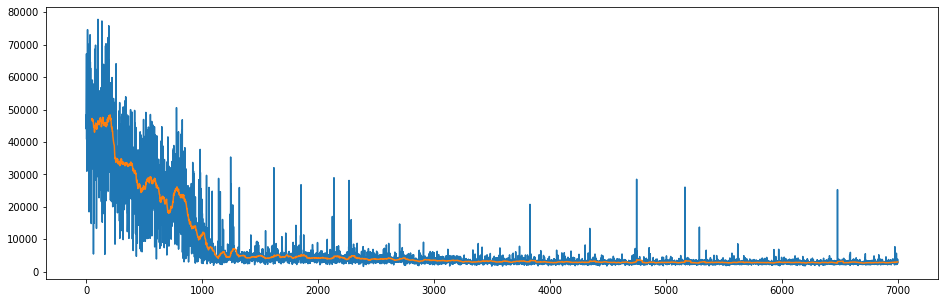

In [28]:
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Total_Cost'].plot(figsize=(16,5))
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Total_Cost'].rolling(50).mean().plot()

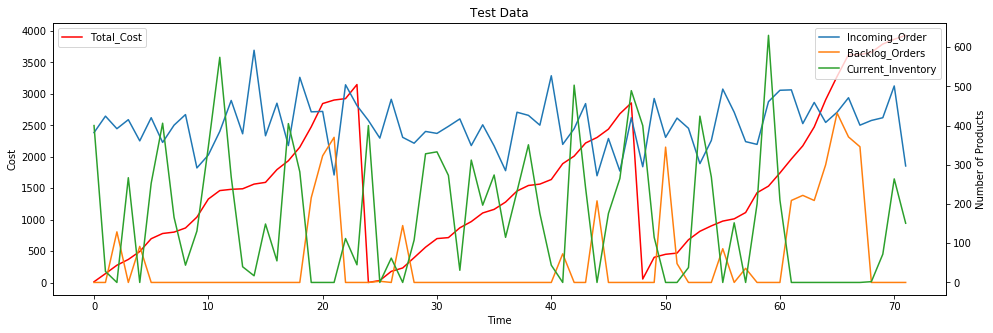

In [25]:
plt.title('Test Data')
ax1 = warehouse_log_test['Total_Cost'].plot(figsize=(16,5), color='r')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cost')
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Products')
warehouse_log_test['Incoming_Order'].plot()
warehouse_log_test['Backlog_Orders'].plot()
warehouse_log_test['Current_Inventory'].plot()
plt.legend();

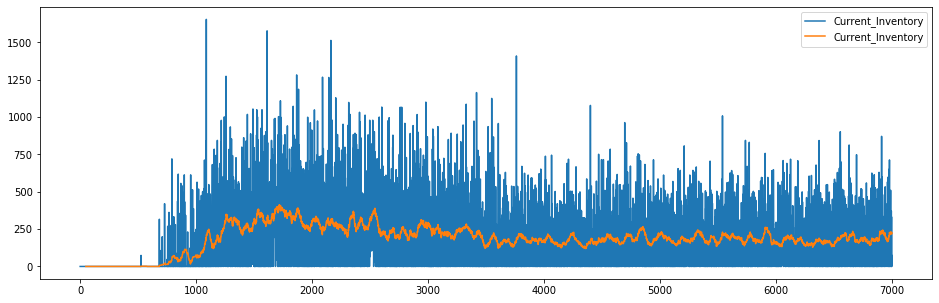

In [34]:
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Current_Inventory'].plot(figsize=(16,5))
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Current_Inventory'].rolling(50).mean().plot()
plt.legend();

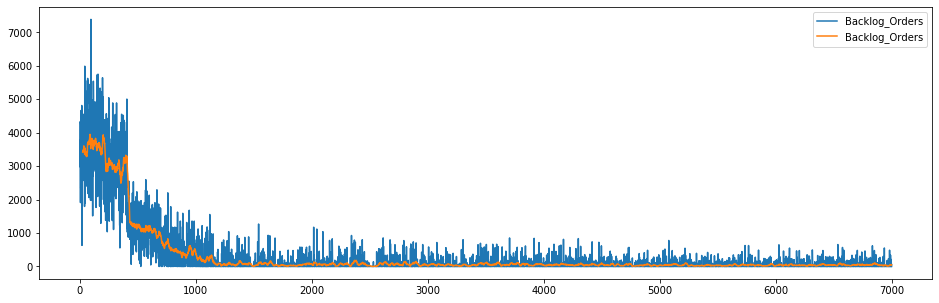

In [35]:
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Backlog_Orders'].plot(figsize=(16,5))
warehouse_log[warehouse_log.week==number_of_weeks-1].reset_index()['Backlog_Orders'].rolling(25).mean().plot()
plt.legend();

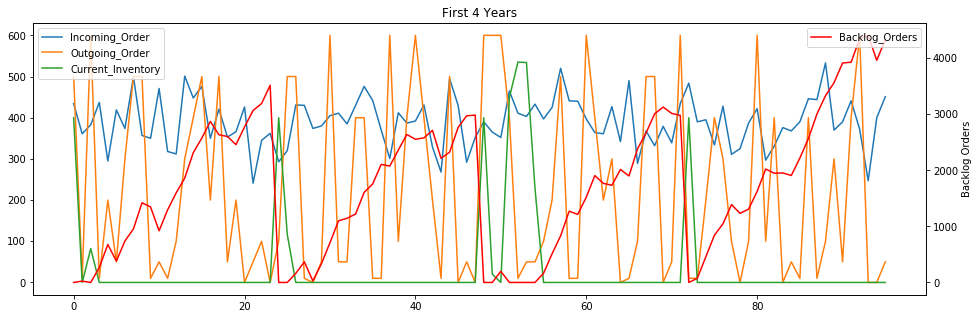

In [36]:
plt.title('First 4 Years')
ax1 = warehouse_log.iloc[:4*number_of_weeks].reset_index()['Incoming_Order'].plot(figsize=(16,5))
warehouse_log.iloc[:4*number_of_weeks].reset_index()['Outgoing_Order'].plot()
warehouse_log.iloc[:4*number_of_weeks].reset_index()['Current_Inventory'].plot()
plt.legend(loc=2);
ax2 = ax1.twinx()
ax2 = warehouse_log.iloc[:4*number_of_weeks].reset_index()['Backlog_Orders'].plot(color='r')
ax2.set_ylabel('Backlog Orders')
plt.legend(loc=1);

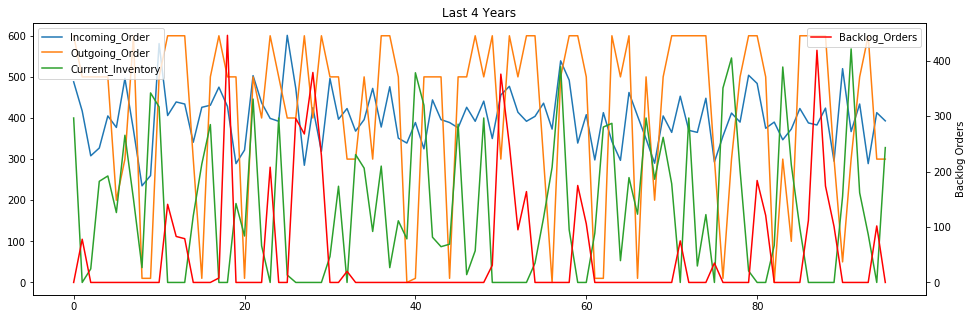

In [37]:
end=episodes*number_of_weeks
start=(episodes-4)*number_of_weeks

plt.title('Last 4 Years')
ax1 = warehouse_log.iloc[start:end].reset_index()['Incoming_Order'].plot(figsize=(16,5))
warehouse_log.iloc[start:end].reset_index()['Outgoing_Order'].plot()
warehouse_log.iloc[start:end].reset_index()['Current_Inventory'].plot()
plt.legend(loc=2);
ax2 = ax1.twinx()
ax2 = warehouse_log.iloc[start:end].reset_index()['Backlog_Orders'].plot(color='r')
ax2.set_ylabel('Backlog Orders')
plt.legend(loc=1);

## prediction

In [39]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    max_value = np.max(d)
    max_key = np.argmax(d)
    return max_key, max_value


def predict_outgoing_order(inventory, backlog):
    s = min(n_bins, max(-n_bins, int((inventory - backlog)*n_bins/max_inventory)))
    print('Current State:', s)
    return all_possible_actions[max_dict(Q[s])[0]]


#Q = read_Q('C:/Users/abhinav.jhanwar/Documents/GMI/repository/Beer Game/Q_value.pickle')
outgoing_order = predict_outgoing_order(400, 0)
print('Please order:', outgoing_order)


Current State: 12
Please order: 10


## start playing beer game

In [27]:
EXE_PATH = r'C:\Users\abhinav.jhanwar\Downloads\chromedriver_win32 (1)\chromedriver.exe'
driver = webdriver.Chrome(executable_path=EXE_PATH)
driver.get('http://beergame.transentis.com/')
time.sleep(5)

# click on cockpit button
element = driver.find_element_by_class_name('button')
element.click()
time.sleep(5)

In [28]:
for i in range(23):
    all_spans = driver.find_elements_by_css_selector("div[class^='instrument']")
    # get incoming order from customer
    incoming_order = int(re.findall(r'[0-9]*', all_spans[1].text)[0])

    # get incoming delivery from plant
    incoming_delivery = int(re.findall(r'[0-9]*', all_spans[4].text)[0])

    # get current inventory
    inventory = int(re.findall(r'[0-9]*', all_spans[5].text)[0])

    # get backlog
    backlog = int(re.findall(r'[0-9]*', all_spans[2].text)[0])

    # get outgoing delivery
    outgoing_delivery = int(re.findall(r'[0-9]*', all_spans[6].text)[0])
    
    print('incoming delivery:', incoming_delivery)
    print('outgoing delivery:', incoming_delivery)
    print('incoming order:',incoming_order)
    print('backlog:', backlog)
    print('inventory:', inventory)
    
    if incoming_order >= inventory + incoming_delivery:
        backlog = backlog + incoming_order - outgoing_delivery
        inventory = 0
    elif incoming_order <= inventory + incoming_delivery - backlog:
        backlog = 0
        inventory = inventory + incoming_delivery - outgoing_delivery
    elif incoming_order > inventory + incoming_delivery - backlog:
        backlog= backlog + incoming_order - outgoing_delivery
        inventory = 0

    print('backlog:', backlog)
    print('inventory:', inventory)

    outgoing_order = predict_outgoing_order(inventory, backlog)
    print('outgoing order:', outgoing_order)

    # fill outgoing_order_value
    element = driver.find_element_by_xpath("//div[@class='input']")
    e2 = element.find_element_by_xpath(".//div")
    e2.send_keys(Keys.BACK_SPACE*4)
    e2.send_keys(outgoing_order)

    # click on order
    element = driver.find_elements_by_xpath("//button")
    element[0].click()

    time.sleep(1)


incoming delivery: 100
outgoing delivery: 100
incoming order: 100
backlog: 0
inventory: 400
backlog: 0
inventory: 400
Current State: 12
outgoing order: 100
incoming delivery: 100
outgoing delivery: 100
incoming order: 100
backlog: 0
inventory: 400
backlog: 0
inventory: 400
Current State: 12
outgoing order: 100
incoming delivery: 100
outgoing delivery: 100
incoming order: 400
backlog: 0
inventory: 400
backlog: 0
inventory: 100
Current State: 3
outgoing order: 600
incoming delivery: 100
outgoing delivery: 100
incoming order: 400
backlog: 0
inventory: 100
backlog: 200
inventory: 0
Current State: -6
outgoing order: 600
incoming delivery: 100
outgoing delivery: 100
incoming order: 400
backlog: 200
inventory: 0
backlog: 500
inventory: 0
Current State: -15
outgoing order: 500
incoming delivery: 500
outgoing delivery: 500
incoming order: 400
backlog: 500
inventory: 0
backlog: 400
inventory: 0
Current State: -12
outgoing order: 600
incoming delivery: 100
outgoing delivery: 100
incoming order: 4